In [1]:
# ==============================================================================
# CELL 1: SETUP AND IMPORTS
# ==============================================================================
import os
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # <-- ADD THIS

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# --- ADD THESE IMPORTS for ROC/AUC ---
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
# ------------------------------------

import kagglehub

print("All libraries imported successfully.")

All libraries imported successfully.


In [2]:
# ==============================================================================
# CELL 2: DOWNLOAD AND PREPARE DATASET
# ==============================================================================
# --- Download from Kaggle ---
import kagglehub
path = kagglehub.dataset_download("mdriyadhossain/ai-medleafx")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-medleafx


In [3]:
dataset_path = "/kaggle/input/ai-medleafx"
print("Verified path to dataset files:", dataset_path)

# Assuming the structure is dataset_path -> 'Resized Image' -> Plant Type -> Disease/Health Status -> Images
resized_image_base_path = os.path.join(dataset_path, 'Resized Image')

all_class_dirs = []
class_counts = {}

print("\nExploring dataset structure and counting images:")

try:
    # List plant type directories within 'Resized Image'
    plant_type_dirs = [d for d in os.listdir(resized_image_base_path) if os.path.isdir(os.path.join(resized_image_base_path, d))]
    print(f"\nFound {len(plant_type_dirs)} plant types:", plant_type_dirs)

    if not plant_type_dirs:
        print("No plant type directories found within 'Resized Image'. Cannot proceed with expected structure.")
    else:
        # Iterate through each plant type directory
        for plant_type_dir in plant_type_dirs:
            plant_type_path = os.path.join(resized_image_base_path, plant_type_dir)

            # List disease/health status directories within each plant type
            status_dirs = [d for d in os.listdir(plant_type_path) if os.path.isdir(os.path.join(plant_type_path, d))]
            print(f"\nExploring '{plant_type_dir}': Found {len(status_dirs)} status categories:", status_dirs)

            if not status_dirs:
                print(f"No status directories found within '{plant_type_dir}'.")
            else:
                # Iterate through each status directory (these are the actual classes)
                for status_dir in status_dirs:
                    class_name = f"{plant_type_dir}_{status_dir}" # Combine plant type and status for a unique class name
                    class_path = os.path.join(plant_type_path, status_dir)
                    all_class_dirs.append(class_name)

                    # Count image files in the class directory
                    image_files_in_class = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg','.JPG'))]
                    class_counts[class_name] = len(image_files_in_class)
                    print(f"- {class_name}: {class_counts[class_name]} images")

        # Determine the total number of classes
        num_classes = len(all_class_dirs)
        print(f"\nTotal number of classes: {num_classes}")

        # Display class distribution summary
        print("\nClass distribution:")
        for class_name, count in class_counts.items():
            print(f"- {class_name}: {count}")

        # Calculate total number of images
        total_images = sum(class_counts.values())
        print(f"\nTotal number of images: {total_images}")

except FileNotFoundError:
    print(f"Error: The directory '{resized_image_base_path}' was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


print("\nDataset exploration and counting complete.")

Verified path to dataset files: /kaggle/input/ai-medleafx

Exploring dataset structure and counting images:

Found 4 plant types: ['Sojina', 'Neem', 'Camphor', 'HariTaki']

Exploring 'Sojina': Found 3 status categories: ['Yellow Leaf', 'Healthy Leaf', 'Bacterial Spot']
- Sojina_Yellow Leaf: 814 images
- Sojina_Healthy Leaf: 860 images
- Sojina_Bacterial Spot: 804 images

Exploring 'Neem': Found 4 status categories: ['Powdery Mildew', 'Yellow Leaf', 'Healthy Leaf', 'Shot Hole Leaf']
- Neem_Powdery Mildew: 854 images
- Neem_Yellow Leaf: 854 images
- Neem_Healthy Leaf: 1021 images
- Neem_Shot Hole Leaf: 834 images

Exploring 'Camphor': Found 3 status categories: ['Healthy Leaf', 'Shot Hole', 'Bacterial Spot']
- Camphor_Healthy Leaf: 800 images
- Camphor_Shot Hole: 795 images
- Camphor_Bacterial Spot: 801 images

Exploring 'HariTaki': Found 3 status categories: ['Healthy Leaf', 'Shot Hole', 'Bacterial Spot']
- HariTaki_Healthy Leaf: 816 images
- HariTaki_Shot Hole: 802 images
- HariTaki_Ba

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
# ==============================================================================
# CELL 3: DATA SPLITTING
# ==============================================================================
import os, shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Define paths
original_base_dir = os.path.join(dataset_path, 'Resized Image')
new_base_dir = '/content/data'

# Collect image paths and labels
data = []
for plant in os.listdir(original_base_dir):
    for status in os.listdir(os.path.join(original_base_dir, plant)):
        label = f"{plant}_{status}"
        path = os.path.join(original_base_dir, plant, status)
        for fname in os.listdir(path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png','.JPG')):
                data.append({'path': os.path.join(path, fname), 'label': label})

df = pd.DataFrame(data)

# Split dataset: 70% train, 15% val, 15% test
train_val, test = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)

# Output summary
total = len(df)
print(f"\n Dataset Split Summary:")
print(f"- Total images: {total}")
print(f"- Training set : {len(train):5d} images ({len(train)/total:.1%})")
print(f"- Validation set: {len(val):5d} images ({len(val)/total:.1%})")
print(f"- Test set     : {len(test):5d} images ({len(test)/total:.1%})\n")

# Copy files
for split_df, split in zip([train, val, test], ['train', 'val', 'test']):
    print(f" Copying {split} files...")
    for _, row in split_df.iterrows():
        dst_dir = os.path.join(new_base_dir, split, row['label'])
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(row['path'], os.path.join(dst_dir, os.path.basename(row['path'])))
    print(f" {split.capitalize()} files copied: {len(split_df)}")

print("\n All files have been split and copied successfully.")


 Dataset Split Summary:
- Total images: 10858
- Training set :  5862 images (54.0%)
- Validation set:   652 images (6.0%)
- Test set     :  4344 images (40.0%)

 Copying train files...
 Train files copied: 5862
 Copying val files...
 Val files copied: 652
 Copying test files...
 Test files copied: 4344

 All files have been split and copied successfully.


In [6]:
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0] == 1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0] == 1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


#  Create ImageFolder Datasets
data_dir = new_base_dir
train_ds = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_tfms)
val_ds   = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=val_tfms)
test_ds  = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=val_tfms)

# STEP 7: Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# STEP 8: Final Checks
print("\n📦 DataLoaders are ready.")
print(f"- Train classes : {train_ds.classes}")
print(f"- Num classes    : {len(train_ds.classes)}")
print(f"- Example image size: {IMG_SIZE}x{IMG_SIZE}")
print("✅ You can now start training!")


📦 DataLoaders are ready.
- Train classes : ['Camphor_Bacterial Spot', 'Camphor_Healthy Leaf', 'Camphor_Shot Hole', 'HariTaki_Bacterial Spot', 'HariTaki_Healthy Leaf', 'HariTaki_Shot Hole', 'Neem_Healthy Leaf', 'Neem_Powdery Mildew', 'Neem_Shot Hole Leaf', 'Neem_Yellow Leaf', 'Sojina_Bacterial Spot', 'Sojina_Healthy Leaf', 'Sojina_Yellow Leaf']
- Num classes    : 13
- Example image size: 224x224
✅ You can now start training!


In [7]:
# ==============================================================================
# CELL 5: DEFINE THE RESNET50 MODEL
# ==============================================================================
class ResNet50(nn.Module):
    def __init__(self, num_classes, pretrained=True, freeze_backbone=True):
        super().__init__()
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.resnet = models.resnet50(weights=weights)

        if freeze_backbone:
            for p in self.resnet.parameters():
                p.requires_grad = False

        # Modify the final fully connected layer for the new number of classes
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

print("ResNet50 model class defined.")

ResNet50 model class defined.


In [8]:
# ==============================================================================
# CELL 6: TRAINING AND EVALUATION LOOP
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(num_classes=len(train_ds.classes), pretrained=False, freeze_backbone=False).to(device)

EPOCHS = 50
best_acc, best_path = 0.0, "medical_plant_best.pth"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW([
    {'params': model.resnet.parameters(), 'lr': 1e-5},
    # {'params': model.densenet.parameters(), 'lr': 1e-5}, # Removed
    # {'params': model.head.parameters(), 'lr': 3e-4} # Removed
], weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- Training and Evaluation Functions ---
def train_one_epoch():
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

# --- Main Training Loop ---

# <<<--- START TRAINING TIMER ---<<<
training_start_time = time.time()

print(f"Starting training for {EPOCHS} epochs on {device}...")
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = evaluate(val_loader)
    scheduler.step()

    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    val_losses.append(va_loss)
    val_accuracies.append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")


    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"state_dict": model.state_dict(), "classes": train_ds.classes}, best_path)
        print(f"✓ Saved new best model to {best_path} (val acc {best_acc:.4f})")

# <<<--- END TRAINING TIMER ---<<<
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nFinished Training. Best Validation Accuracy: {best_acc:.4f}")
print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")


# --- Final Evaluation on Test Set ---
print("\nPerforming final evaluation on the unseen test set...")
model.load_state_dict(torch.load(best_path)["state_dict"])

# <<<--- START TESTING TIMER ---<<<
testing_start_time = time.time()

test_loss, test_acc = evaluate(test_loader)

# <<<--- END TESTING TIMER ---<<<
testing_end_time = time.time()
total_testing_time = testing_end_time - testing_start_time

# input_tensor = torch.randn(1, 3, 224, 224).to(device)
# gflops = calculate_gflops(model, input_tensor)  # Ensure calculate_gflops function is defined elsewhere
# print(f"GFLOPs: {gflops:.3f} GFLOPs")

print(f"FINAL TEST RESULTS -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")
print(f"Testing Time: {total_testing_time:.2f} seconds")



Starting training for 50 epochs on cuda...
Epoch 01 | Train Loss 2.4181 Acc 0.1904 | Val Loss 2.2102 Acc 0.3052
✓ Saved new best model to medical_plant_best.pth (val acc 0.3052)
Epoch 02 | Train Loss 2.0817 Acc 0.3514 | Val Loss 1.8133 Acc 0.4356
✓ Saved new best model to medical_plant_best.pth (val acc 0.4356)
Epoch 03 | Train Loss 1.7741 Acc 0.4748 | Val Loss 1.5768 Acc 0.5353
✓ Saved new best model to medical_plant_best.pth (val acc 0.5353)
Epoch 04 | Train Loss 1.6255 Acc 0.5264 | Val Loss 1.4487 Acc 0.5905
✓ Saved new best model to medical_plant_best.pth (val acc 0.5905)
Epoch 05 | Train Loss 1.5188 Acc 0.5821 | Val Loss 1.3626 Acc 0.6258
✓ Saved new best model to medical_plant_best.pth (val acc 0.6258)
Epoch 06 | Train Loss 1.4374 Acc 0.6182 | Val Loss 1.3061 Acc 0.6718
✓ Saved new best model to medical_plant_best.pth (val acc 0.6718)
Epoch 07 | Train Loss 1.3699 Acc 0.6428 | Val Loss 1.2521 Acc 0.7101
✓ Saved new best model to medical_plant_best.pth (val acc 0.7101)
Epoch 08 | T

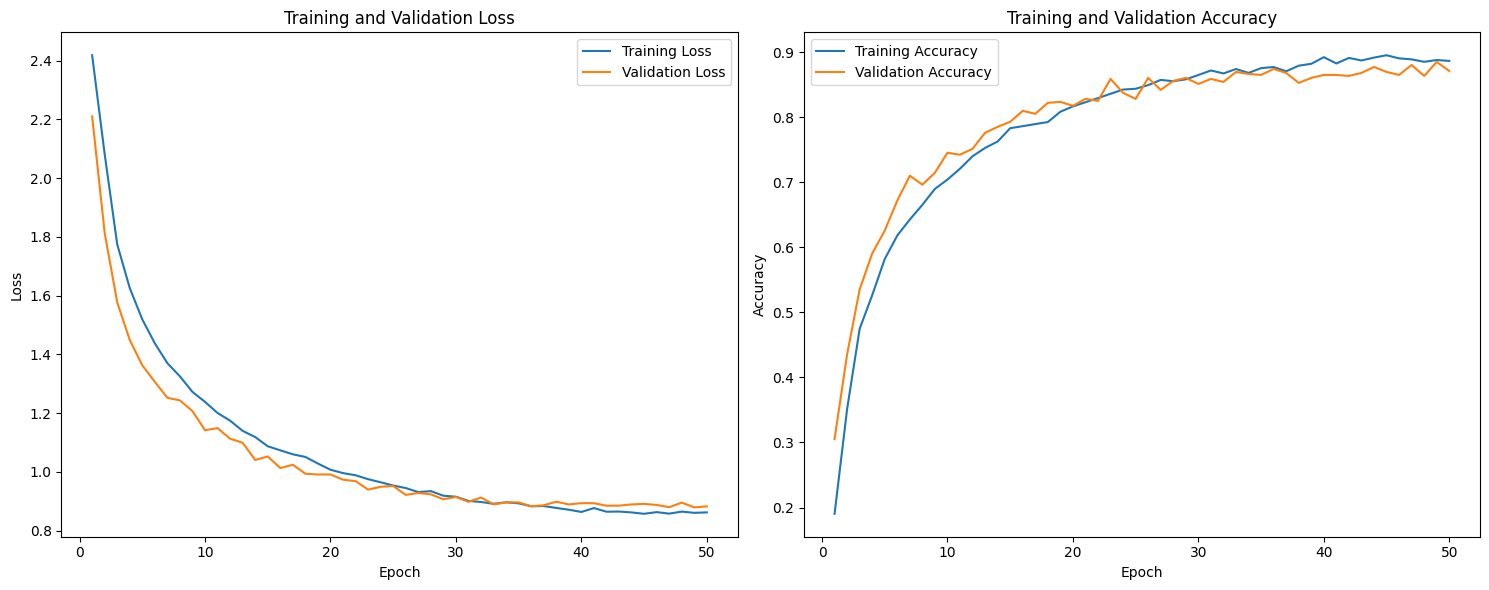

In [9]:
# ==============================================================================
# CELL 7: PLOT TRAINING HISTORY
# ==============================================================================
plt.figure(figsize=(15, 6))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


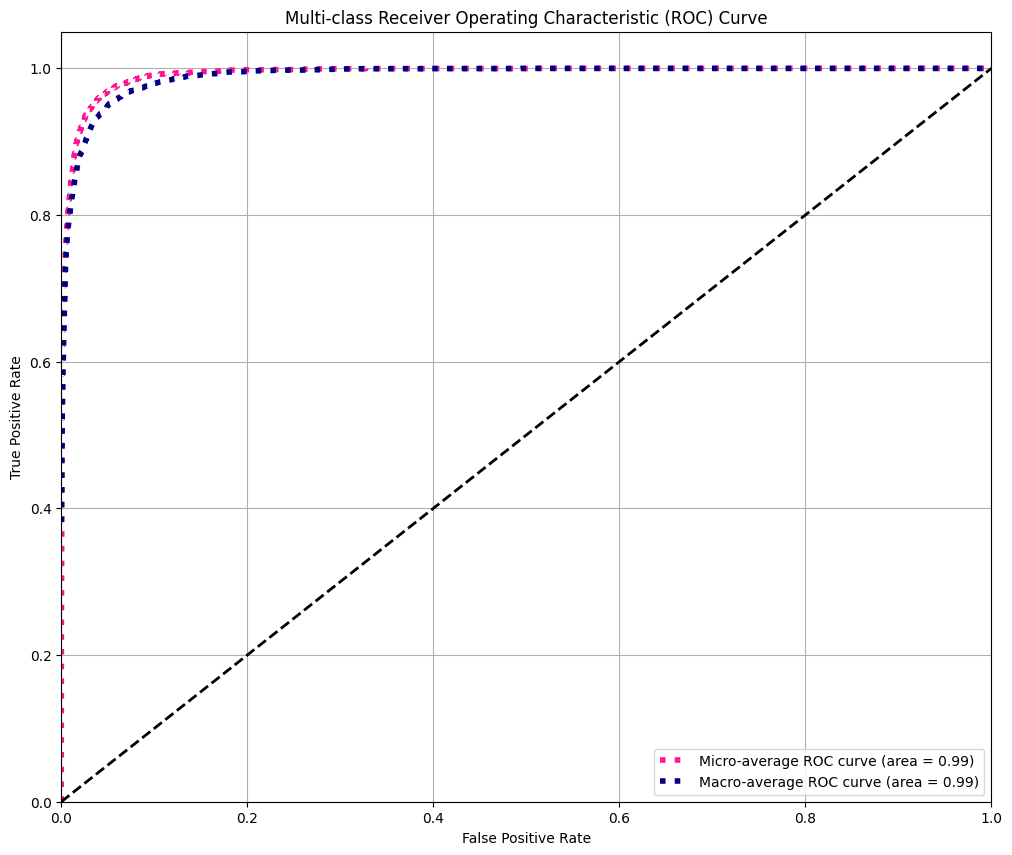

In [10]:
# ==============================================================================
# CELL 8: GET PREDICTIONS AND PLOT AUC/ROC CURVE
# ==============================================================================

@torch.no_grad()
def get_predictions_and_labels(model, loader):
    """Function to get model predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        # Apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        all_preds.append(probabilities.cpu().numpy())
        all_labels.append(y.cpu().numpy())
    return np.vstack(all_preds), np.concatenate(all_labels)

# --- Get Predictions ---
y_pred_probs, y_true = get_predictions_and_labels(model, test_loader)
class_names = train_ds.classes
n_classes = len(class_names)

# --- Binarize the labels for multiclass ROC ---
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# --- Compute ROC curve and ROC area for each class ---
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro-average ROC curve and ROC area ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Compute macro-average ROC curve and ROC area ---
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot all ROC curves ---
plt.figure(figsize=(12, 10))

# Plot Micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot Macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

# Optional: Plot ROC for a few classes if desired (plotting all 44 would be messy)
# colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
# for i, color in zip(range(5), colors): # Plot first 5 classes
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot the "no-skill" line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [11]:
# ==============================================================================
# CELL 9: DETAILED REPORT AND CONFUSION MATRIX ON TEST SET
# ==============================================================================
print("\nGenerating final report and confusion matrix on the TEST SET...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes, digits=4))




Generating final report and confusion matrix on the TEST SET...

Classification Report:
                         precision    recall  f1-score   support

 Camphor_Bacterial Spot     0.9231    0.9375    0.9302       320
   Camphor_Healthy Leaf     0.8407    0.8906    0.8649       320
      Camphor_Shot Hole     0.8544    0.8302    0.8421       318
HariTaki_Bacterial Spot     0.7673    0.6573    0.7081       321
  HariTaki_Healthy Leaf     0.8283    0.9172    0.8705       326
     HariTaki_Shot Hole     0.7810    0.7664    0.7736       321
      Neem_Healthy Leaf     0.7956    0.7917    0.7936       408
    Neem_Powdery Mildew     0.7224    0.7456    0.7338       342
    Neem_Shot Hole Leaf     0.7325    0.7216    0.7270       334
       Neem_Yellow Leaf     0.9591    0.9591    0.9591       342
  Sojina_Bacterial Spot     0.9815    0.9876    0.9845       322
    Sojina_Healthy Leaf     1.0000    0.9797    0.9897       344
     Sojina_Yellow Leaf     0.9878    0.9969    0.9924       326


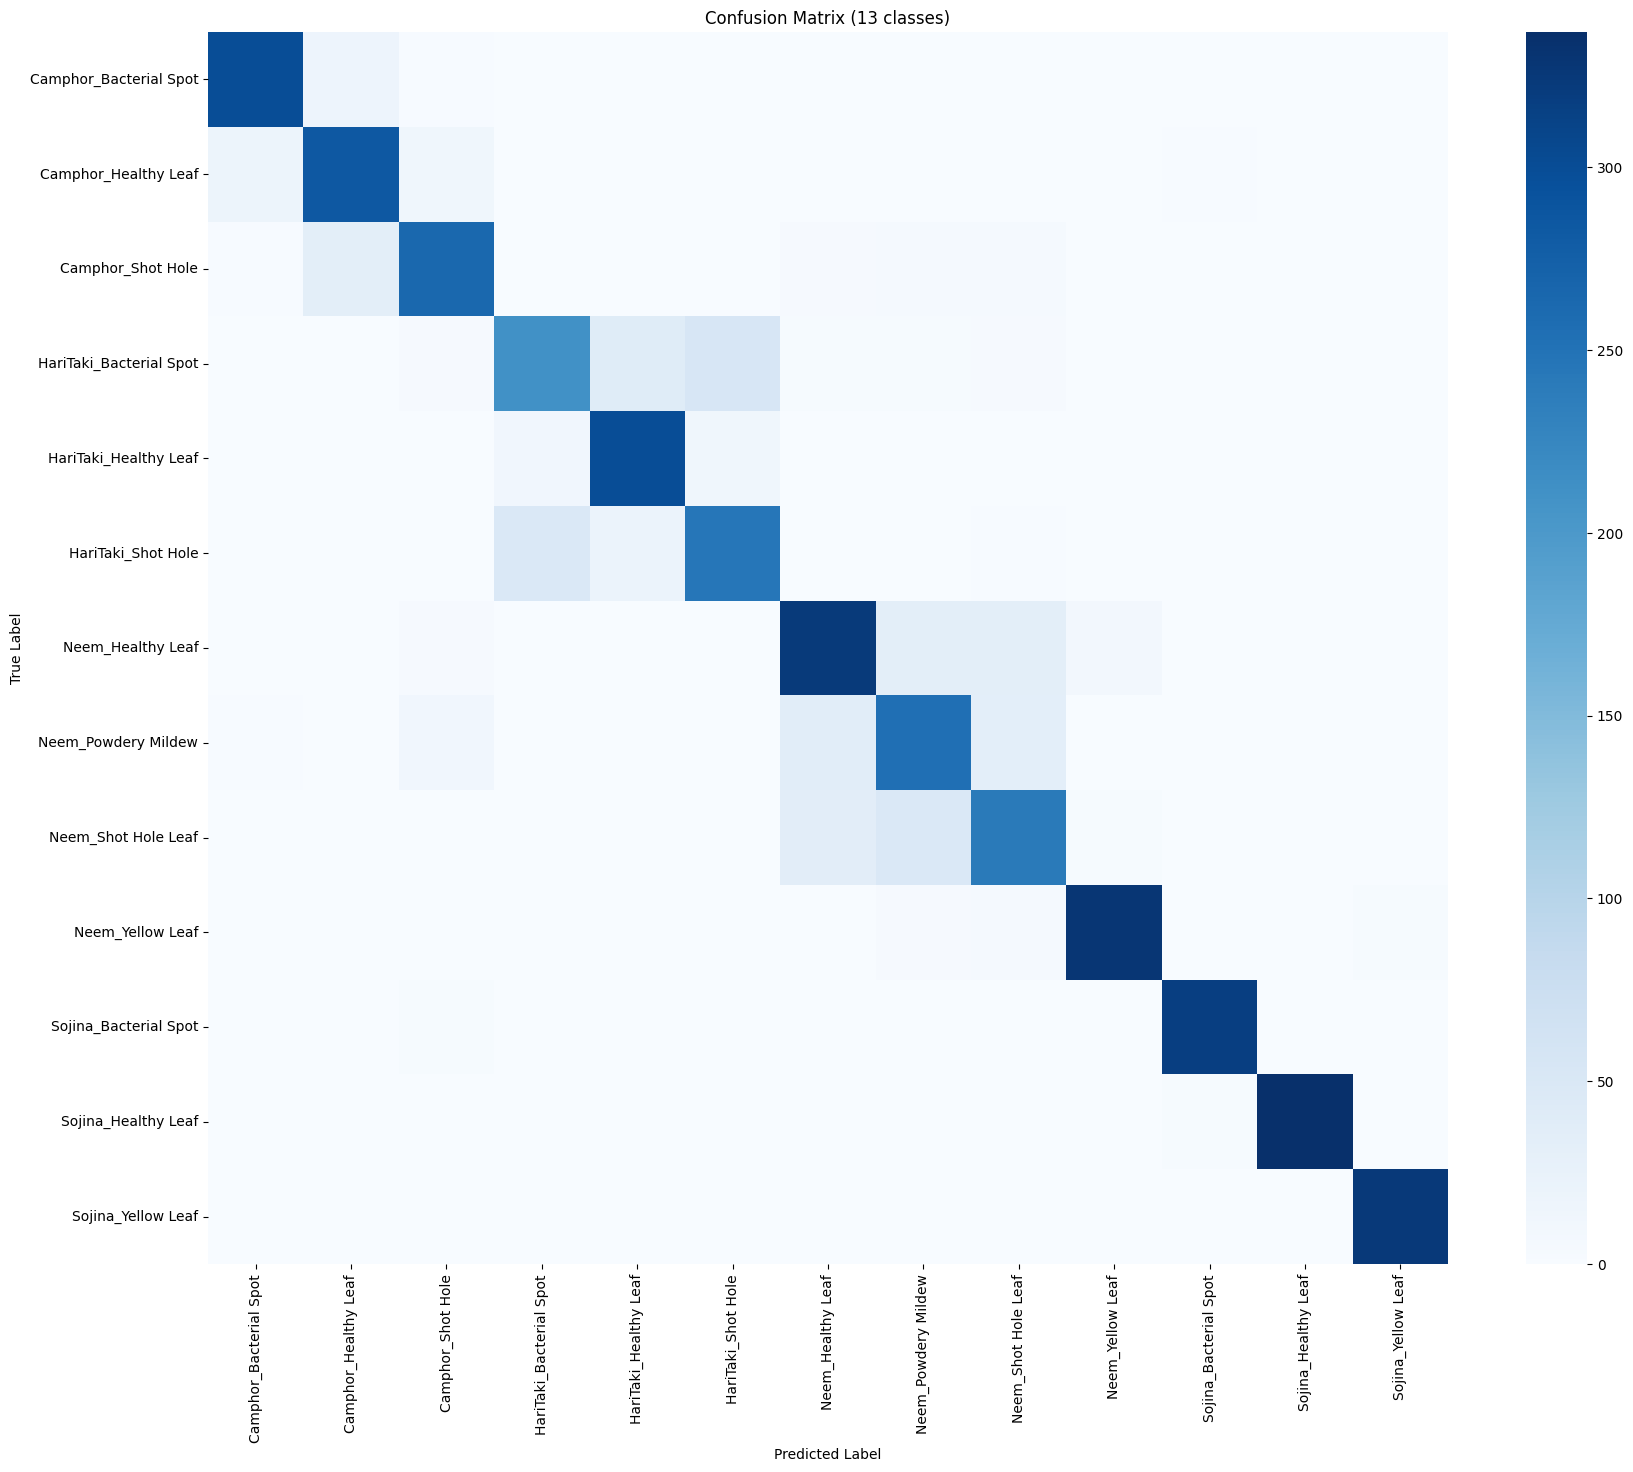

In [12]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title(f"Confusion Matrix ({len(test_ds.classes)} classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from pynvml import *
import time

# ---- GPU setup ----
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)

def get_power_watts():
    return nvmlDeviceGetPowerUsage(handle) / 1000

# ---- Your dataset ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# ---- Model ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet50(pretrained=False).to(device)
model.eval()

# ---- Measurement ----
energy_joules = 0
start_time = time.time()

with torch.no_grad():
    for images, _ in loader:
        images = images.to(device)
        t0 = time.time()
        power = get_power_watts()
        _ = model(images)
        torch.cuda.synchronize()
        t1 = time.time()
        energy_joules += power * (t1 - t0)

end_time = time.time()
duration = end_time - start_time
avg_power = energy_joules / duration

print(f"\nTotal energy used: {energy_joules:.2f} J")
print(f"Average GPU power: {avg_power:.2f} W")
print(f"Total time: {duration:.2f} s")

nvmlShutdown()


100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Total energy used: 990.21 J
Average GPU power: 37.58 W
Total time: 26.35 s


# Baseline Model

The ResNet50 model trained in the previous steps using supervised learning will serve as the baseline model for comparison with future experiments involving Self-Supervised Learning (SSL).

Its performance metrics (Accuracy, Classification Report, Confusion Matrix, ROC/AUC) and complexity (GFLOPs, Parameters) will be used to evaluate the effectiveness of SSL approaches.

## Supervised Baseline Model Summary

Here's a brief summary of the top-1 accuracy achieved by the supervised ResNet50 baseline model on the test set:

| Metric          | Value   |
|-----------------|---------|
| Test Accuracy   | {{test_acc:.4f}} |

To share this notebook on Kaggle, you can use the sharing options available within the Kaggle notebook interface.

The logs from the training process are visible in the output of the code cells above.